In [18]:
import scipy as sc
import math as m
import matplotlib as mp
from matplotlib import pyplot as pl
import datetime as d
import numpy as np
from numpy import random as r

In [13]:
run_start = d.datetime.utcnow(); #Use this if this notebook initiates the data collection
print(run_start);
#run_start = 'ex' Use if you wish to manually input the run start

2018-06-07 13:46:02.557903


In [14]:
thres_volt='10 mV';
comment='Fill with any comments';
temp='ex';
freq='50MHz';                    #Should be changed if a different clock speed is used

In [39]:
data=r.randint(2, size=(12285,400));
runs=int(len(data[:,0])/4095);
test_data= np.empty([4095, 400, runs]);
for n in range(runs):
    for m in range((n*4095),((n+1)*4095)):
        for i in range(400):
            test_data[(m-(n*4095))][i][n]=data[m][i];
print(test_data);

[[[ 0.  0.  1.]
  [ 1.  1.  0.]
  [ 1.  0.  1.]
  ..., 
  [ 1.  0.  0.]
  [ 1.  1.  0.]
  [ 0.  1.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  1.  1.]
  ..., 
  [ 0.  0.  1.]
  [ 1.  0.  1.]
  [ 1.  0.  1.]]

 [[ 0.  0.  1.]
  [ 1.  1.  1.]
  [ 1.  1.  0.]
  ..., 
  [ 0.  0.  1.]
  [ 0.  0.  0.]
  [ 0.  1.  1.]]

 ..., 
 [[ 1.  0.  0.]
  [ 0.  0.  0.]
  [ 1.  0.  0.]
  ..., 
  [ 1.  1.  0.]
  [ 1.  0.  0.]
  [ 0.  1.  0.]]

 [[ 1.  0.  1.]
  [ 0.  1.  1.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  1.]
  [ 1.  0.  1.]
  [ 0.  0.  0.]]

 [[ 1.  0.  0.]
  [ 0.  1.  1.]
  [ 1.  1.  0.]
  ..., 
  [ 1.  0.  0.]
  [ 1.  1.  0.]
  [ 0.  0.  1.]]]


In [24]:
#test_data = np.empty([4095,400,4]);
#test_data = r.randint(2, size=(4095,400,4))
#run_store = np.savez('chronopixel_run_%s' %run_start, test_data); 
#time=[n for n in range(4095)];
#print('chronopixel_run_%s' %run_start);

chronopixel_run_2018-06-07 13:46:02.557903
<class 'numpy.ndarray'>


In [16]:
hits=np.empty([len(test_data[:,0,0]),len(test_data[0,0,:])]);
for n in range(len(test_data[0,0,:])):
    for m in range(len(test_data[:,0,0])):
        hits[m][n]=sum(test_data[m,:,n]);
hits_store=run_store = np.savez_compressed('chronopixel_hits_%s' %run_start, hits); 
#I am getting an error when saving the files. It says the file is not UTF-8 encoded and so saving has been disabled.

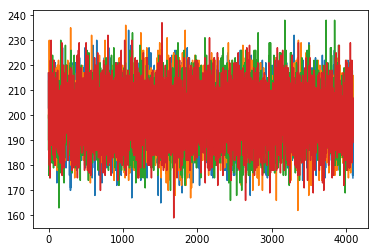

In [107]:
pl.plot(time,hits);
pl.show();

In [109]:
avr_hits=np.empty(len(hits[0]))
for n in range(len(hits[0])):
    avr_hits[n]=sum(hits[:,n])/len(hits[:,n])
print(avr_hits);

[ 200.002442    200.37191697  199.86275946  199.75506716]
